# DELIVERABLE: FINE-TUNING AND ADAPTATION OF LANGUAGE MODELS

In this exercise the aim is to perform transfer learning from English to Spanish in the domain of sentiment analysis in opinions about movies.
It is recommended to use a cross-lingual model in order to facilitate the learning transfer.

- `xlm-roberta-base`
- `xlm-roberta-large`

In [ ]:
#pip install --upgrade bigframes
!pip install bigframes

In [ ]:

!pip install ibis-framework

#pip install --upgrade ibis-framework

Choose between transformers or simpletransformers

In [ ]:
!pip install transformers[torch]


In [ ]:
!pip install -q datasets

## Loading, exploring and transforming data for tranformers

Get the data of opinions about movies from IMDB dataset (parquet format)

In [ ]:
!wget -O imdb_train.parquet "https://huggingface.co/datasets/imdb/resolve/refs%2Fconvert%2Fparquet/plain_text/train/0000.parquet"
!wget -O imdb_test.parquet  "https://huggingface.co/datasets/imdb/resolve/refs%2Fconvert%2Fparquet/plain_text/test/0000.parquet"

# PART I: Training with the English dataset

In [6]:
!ls

imdb_test.parquet  imdb_train.parquet  sample_data


In [7]:
#import pyarrow.parquet as pq

#train_table = pq.read_table("imdb_train.parquet")
##test_table = pq.read_table("imdb_test.parquet")

#train_df = train_table.to_pandas()
#test_df = test_table.to_pandas()

In [8]:
import pandas as pd
train_df = pd.read_parquet("imdb_train.parquet")
test_df = pd.read_parquet("imdb_test.parquet")

### Loading, exploring and transforming data for tranformers

In [9]:
# Viewing information about datasets.
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None


In [10]:
# Viewing the first records of the training dataset.
print(train_df.head())

                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0


In [11]:
# Distribution of classes in the training dataset.
print(train_df['label'].value_counts(normalize=True))

0    0.5
1    0.5
Name: label, dtype: float64


### Get the tokenizer and the classification model (xlm-roberta-base)

In [12]:
##Very Very LONG
from transformers import AutoTokenizer

# Loading the tokenizer.
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

# Function for tokenizing the dataset.
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
##Thiss is Shoter
#from transformers import AutoTokenizer

#model_name = "microsoft/MiniLM-L12-H384-uncased" #recommended: microsoft/MiniLM-L12-H384-uncased
#tokenizer = AutoTokenizer.from_pretrained(model_name)

# Функция для токенизации датасета
#def tokenize_function(examples):
    #return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

In [13]:
# Tokenization of the data.
train_tokenized = tokenize_function(train_df.to_dict(orient='list'))
test_tokenized = tokenize_function(test_df.to_dict(orient='list'))

In [14]:
import torch

# Conversion of tokenized data into PyTorch tensors.
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Creation of dataset objects for training and testing.
train_dataset = IMDbDataset(train_tokenized, train_df['label'].tolist())
test_dataset = IMDbDataset(test_tokenized, test_df['label'].tolist())

### Prepare the Trainer from a cross-lingual pretrained model

In [15]:
#IMDB is a binary classification task, so the number of class labels (num_labels) would be 2.
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=2)


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
#2:Setting up training arguments.
training_args = TrainingArguments(
    output_dir='./results',          # Directory for saving results
    num_train_epochs=5,              # Number of training epochs
    per_device_train_batch_size=48,   # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps
    weight_decay=0.01,               # Weight decay
    logging_dir='./logs',            # Directory for logs
    logging_steps=10,                # Logging frequency
    evaluation_strategy="epoch",     # Evaluation strategy
    save_strategy="epoch",           # Model saving strategy
    load_best_model_at_end=True,     # Load the best model at the end of training
    metric_for_best_model="accuracy" # Metric for selecting the best model
)


In [33]:
# 3: Definition of a function for calculating metrics.
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='binary')
    return {'accuracy': acc, 'f1': f1}

### Prepare the arguments of the trainer and set the trained object

In [34]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

### Train

In [35]:
# Запуск обучения
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.223000,0.236538,0.916800,0.920586
2,0.163200,0.164512,0.938480,0.939123
3,0.114800,0.198857,0.936160,0.934862
4,0.063600,0.239792,0.939880,0.940950
5,0.026600,0.297615,0.940880,0.941907


TrainOutput(global_step=2605, training_loss=0.15123920946197866, metrics={'train_runtime': 3645.8703, 'train_samples_per_second': 34.285, 'train_steps_per_second': 0.715, 'total_flos': 3.288888192e+16, 'train_loss': 0.15123920946197866, 'epoch': 5.0})

### Evaluate the model with the test dataset (English)

In [36]:
# Model evaluation on the test dataset.
trainer.evaluate(test_dataset)

{'eval_loss': 0.2976151406764984,
 'eval_accuracy': 0.94088,
 'eval_f1': 0.9419070827765113,
 'eval_runtime': 185.0788,
 'eval_samples_per_second': 135.078,
 'eval_steps_per_second': 8.445,
 'epoch': 5.0}

In [37]:
import os

model_path = 'D:/BDModel/model'
tokenizer_path = 'D:/BDModel/tokenizer'

# Создание директорий, если они еще не существуют
if not os.path.exists(model_path):
    os.makedirs(model_path)
if not os.path.exists(tokenizer_path):
    os.makedirs(tokenizer_path)

# Сохранение модели и токенизатора
model.save_pretrained(model_path)
tokenizer.save_pretrained(tokenizer_path)


('D:/BDModel/tokenizer/tokenizer_config.json',
 'D:/BDModel/tokenizer/special_tokens_map.json',
 'D:/BDModel/tokenizer/sentencepiece.bpe.model',
 'D:/BDModel/tokenizer/added_tokens.json',
 'D:/BDModel/tokenizer/tokenizer.json')

In [38]:
model_path = './BDModel/model'
tokenizer_path = './BDModel/tokenizer'

# Создание директорий, если они еще не существуют
if not os.path.exists(model_path):
    os.makedirs(model_path)
if not os.path.exists(tokenizer_path):
    os.makedirs(tokenizer_path)

# Сохранение модели и токенизатора
model.save_pretrained(model_path)
tokenizer.save_pretrained(tokenizer_path)

('./BDModel/tokenizer/tokenizer_config.json',
 './BDModel/tokenizer/special_tokens_map.json',
 './BDModel/tokenizer/sentencepiece.bpe.model',
 './BDModel/tokenizer/added_tokens.json',
 './BDModel/tokenizer/tokenizer.json')

In [39]:
import zipfile

# Путь к папке BDModel
folder_path = './BDModel'

# Путь к архивному файлу, который вы хотите создать
zip_file_path = './BDModel_archive.zip'

# Создание архива
with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Рекурсивное добавление всех файлов и подпапок из папки BDModel в архив
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join(folder_path, '..')))


### Get the tokenizer and the classification model (from_pretrained)

In [118]:
#from transformers import AutoTokenizer
#Путь к сохраненному токенизатору
tokenizer_path = 'D:/BDModel/tokenizer'

# Загрузка токенизатора из локальной директории
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)


In [119]:
#from transformers import AutoModelForSequenceClassification

# Путь к сохраненной модели
model_path = 'D:/BDModel/model'

# Загрузка модели из локальной директории
model = AutoModelForSequenceClassification.from_pretrained(model_path)


In [120]:
# Пример текста для классификации Example text for classification
text = "This movie was fantastic! I loved it."

# Токенизация текста Tokenization of the text
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Получение предсказаний от модели Getting predictions from the model
outputs = model(**inputs)

# Преобразование выходных данных модели в вероятности Conversion of the model's output into probabilities
import torch.nn.functional as F
probs = F.softmax(outputs.logits, dim=-1)

# Вывод вероятностей для каждого класса Displaying the probabilities for each class
print(probs)


tensor([[0.0011, 0.9989]], grad_fn=<SoftmaxBackward0>)


In [121]:
# Пример текста для классификации
text = "This movie bad."

# Токенизация текста
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Получение предсказаний от модели
outputs = model(**inputs)

# Преобразование выходных данных модели в вероятности
import torch.nn.functional as F
probs = F.softmax(outputs.logits, dim=-1)

# Вывод вероятностей для каждого класса
print(probs)

tensor([[9.9937e-01, 6.2613e-04]], grad_fn=<SoftmaxBackward0>)


# Part II: Adaptation to Spanish dataset (criticas_pelis)

### Load, explore and transform the Spanish dataset of Critics

In [47]:
!wget https://krono.act.uji.es/IDIA/criticas_pelis.csv.gz
!gunzip criticas_pelis.csv.gz

--2024-02-12 15:54:25--  https://krono.act.uji.es/IDIA/criticas_pelis.csv.gz
Resolving krono.act.uji.es (krono.act.uji.es)... 150.128.97.37
Connecting to krono.act.uji.es (krono.act.uji.es)|150.128.97.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4447654 (4.2M) [application/x-gzip]
Saving to: ‘criticas_pelis.csv.gz’

criticas_pelis.csv. 100%[===================>]   4.24M  4.04MB/s    in 1.1s    

2024-02-12 15:54:27 (4.04 MB/s) - ‘criticas_pelis.csv.gz’ saved [4447654/4447654]



In [49]:
df = pd.read_csv("criticas_pelis.csv", names=["Row", "File", "Text", "Rating"])
df.head()

,Row,File,Text,Rating
0,Row0,File-0,"May, ¿quieres ser mi amigo? May, ¿Quieres ser...",4
1,Row1,File-1,Cómo ponerse en la piel de un kamikaze Es tod...,4
2,Row2,File-10,"Deliciosa comedieta dramática, con tintes rev...",4
3,Row3,File-100,La ironía es el arma de los perdedores y este...,3
4,Row4,File-1000,"Al final, y teniendo en cuenta que esto es el...",3


In [52]:
# Loading the dataset with specified column names
df = pd.read_csv("criticas_pelis.csv", names=["Row", "File", "Text", "Rating"])

# Removing the columns "Row" and "File"
df = df.drop(['Row', 'File'], axis=1)

# Preliminary data analysis
print(df.head())
print(df.describe())

# Filtering neutral reviews and converting ratings to binary labels
df_filtered = df[df['Rating'] != 3].copy()  # Использование .copy() для избежания предупреждения
df_filtered['Label'] = df_filtered['Rating'].apply(lambda x: 1 if x > 3 else 0)

# Checking the distribution of labels after transformation
print(df_filtered['Label'].value_counts())
print(df_filtered.head())

                                                Text  Rating
0   May, ¿quieres ser mi amigo? May, ¿Quieres ser...       4
1   Cómo ponerse en la piel de un kamikaze Es tod...       4
2   Deliciosa comedieta dramática, con tintes rev...       4
3   La ironía es el arma de los perdedores y este...       3
4   Al final, y teniendo en cuenta que esto es el...       3
            Rating
count  3878.000000
mean      3.048221
std       1.141519
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       5.000000
1    1351
0    1274
Name: Label, dtype: int64
                                                Text  Rating  Label
0   May, ¿quieres ser mi amigo? May, ¿Quieres ser...       4      1
1   Cómo ponerse en la piel de un kamikaze Es tod...       4      1
2   Deliciosa comedieta dramática, con tintes rev...       4      1
5   Durante buena parte del metraje y solo pude r...       1      0
8   Sus defectos quedan olvidados gracias a las i...       4      1


### Prepare the Trainer from the previous trained model

In [68]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_filtered['Text'], df_filtered['Label'],
    test_size=0.1,  # 10% данных для валидации
    random_state=42  # Задаем seed для воспроизводимости
)

In [69]:
# Tokenization of the training dataset
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=512)

# Tokenization of the validation dataset
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=512)

In [70]:
# Создание датасетов для тренировки и валидации
class CriticasPelisDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [71]:
train_dataset = CriticasPelisDataset(train_encodings, train_labels.tolist())
val_dataset = CriticasPelisDataset(val_encodings, val_labels.tolist())

In [76]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [83]:
training_args = TrainingArguments(
    output_dir='./results',          # Folder to save results
    num_train_epochs=10,              # Number of training epochs
    per_device_train_batch_size=48,   # Batch size for training
    per_device_eval_batch_size=48,    # Batch size for evaluation
    warmup_steps=500,                 # Number of warm-up steps
    weight_decay=0.01,                # Weight decay coefficient
    evaluation_strategy="epoch",      # Evaluation strategy
    save_strategy="epoch",            # Saving strategy for the model
    logging_dir='./logs',             # Folder for logs
    logging_steps=10,
    load_best_model_at_end=True,      # Load the best model at the end of training
    metric_for_best_model="f1",       # Metric for determining the best model
    greater_is_better=True            # Indicates that larger metric values are better
)
#metric_for_best_model="accuracy" # Metric for selecting the best model


In [84]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset  # Используем валидационный набор данных
)

In [85]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.001400,0.380107,0.923954,0.925926,0.892857,0.961538
2,0.004800,0.447976,0.923954,0.925373,0.898551,0.953846
3,0.012300,0.559094,0.916350,0.917910,0.891304,0.946154
4,0.000200,0.564360,0.916350,0.918519,0.885714,0.953846
5,0.000300,0.566810,0.920152,0.923077,0.881119,0.969231
6,0.135400,0.284045,0.923954,0.921875,0.936508,0.907692
7,0.141600,0.236732,0.931559,0.929687,0.944444,0.915385
8,0.030600,0.449992,0.923954,0.927536,0.876712,0.984615
9,0.056700,0.451270,0.923954,0.921875,0.936508,0.907692
10,0.089800,0.390966,0.939163,0.939850,0.919118,0.961538


TrainOutput(global_step=500, training_loss=0.04847958060866222, metrics={'train_runtime': 628.7316, 'train_samples_per_second': 37.568, 'train_steps_per_second': 0.795, 'total_flos': 6214683127603200.0, 'train_loss': 0.04847958060866222, 'epoch': 10.0})

### Evaluate the model with the test dataset (Spanish)

In [110]:
# Model evaluation on the validation dataset
eval_results = trainer.evaluate(val_dataset)

In [111]:
# Outputting evaluation results
print(eval_results)

{'eval_loss': 0.39096590876579285, 'eval_accuracy': 0.9391634980988594, 'eval_f1': 0.9398496240601504, 'eval_precision': 0.9191176470588235, 'eval_recall': 0.9615384615384616, 'eval_runtime': 1.8782, 'eval_samples_per_second': 140.028, 'eval_steps_per_second': 3.195, 'epoch': 10.0}


In [88]:
model.save_pretrained('./fine_tuned_model')
tokenizer.save_pretrained('./fine_tuned_model')


('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/sentencepiece.bpe.model',
 './fine_tuned_model/added_tokens.json',
 './fine_tuned_model/tokenizer.json')

In [113]:
# Getting predictions on the validation dataset
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=1)


In [122]:
# True labels from the validation dataset
true_labels = val_labels.tolist()

# Comparing predictions with true labels for the first 10 positions
for i in range(min(10, len(true_labels))):  # Используем min() для обработки случаев, когда длина меньше 10
    print(f"True Label : {true_labels[i]}, Prediction: {preds[i]}")


True Label : 1, Prediction: 1
True Label : 0, Prediction: 0
True Label : 0, Prediction: 0
True Label : 1, Prediction: 1
True Label : 1, Prediction: 1
True Label : 1, Prediction: 1
True Label : 1, Prediction: 1
True Label : 0, Prediction: 0
True Label : 0, Prediction: 0
True Label : 0, Prediction: 0


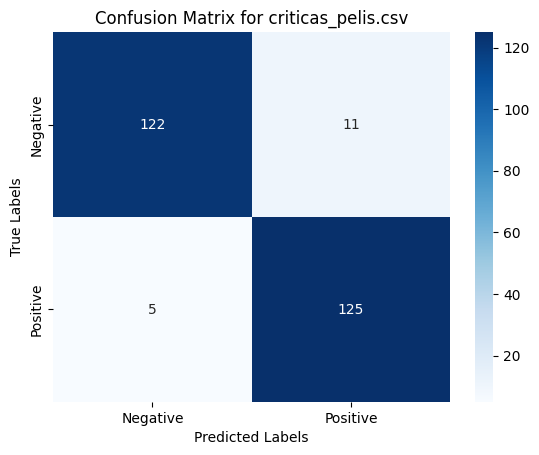

In [123]:
# Построение матрицы ошибок
cm = confusion_matrix(true_labels, preds)

# Визуализация матрицы ошибок
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix for criticas_pelis.csv')
plt.show()


In [124]:
# Расчет правильных и неправильных предсказаний
correct_predictions = np.sum(true_labels == preds)
incorrect_predictions = np.sum(true_labels != preds)
total_predictions = len(true_labels)

# Вывод результатов
print(f"Correct Predictions: {correct_predictions}")
print(f"Incorrect Predictions: {incorrect_predictions}")
print(f"Total Predictions: {total_predictions}")


Correct Predictions: 247
Incorrect Predictions: 16
Total Predictions: 263


### Evaluate again the model on the English test dataset

In [89]:
# Загрузка тестового набора данных
test_df = pd.read_parquet("imdb_test.parquet")

# Вывод первых нескольких строк для проверки
print(test_df.head())

# Вывод распределения меток в тестовом наборе данных
print(test_df['label'].value_counts())

# Токенизация тестового набора данных
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True, max_length=512, return_tensors="pt")

                                                text  label
0  I love sci-fi and am willing to put up with a ...      0
1  Worth the entertainment value of a rental, esp...      0
2  its a totally average film with a few semi-alr...      0
3  STAR RATING: ***** Saturday Night **** Friday ...      0
4  First off let me say, If you haven't enjoyed a...      0
0    12500
1    12500
Name: label, dtype: int64


In [125]:
class IMDbDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: self.encodings[key][idx] for key in self.encodings}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

test_dataset = IMDbDataset(test_encodings, test_df['label'].tolist())

# Вывод размера тестового набора данных
print("Size of the test dataset:", len(test_dataset))

Size of the test dataset: 25000


In [126]:
# Оценка модели на тестовом наборе данных
eval_results = trainer.evaluate(test_dataset)

# Вывод результатов оценки
print("Evaluation results on the test dataset:")
print(eval_results)


Evaluation results on the test dataset:
{'eval_loss': 0.4491254389286041, 'eval_accuracy': 0.92768, 'eval_f1': 0.9268134715025907, 'eval_precision': 0.9380530973451328, 'eval_recall': 0.91584, 'eval_runtime': 168.7039, 'eval_samples_per_second': 148.189, 'eval_steps_per_second': 3.088, 'epoch': 10.0}


In [93]:
# Получение предсказаний модели
import numpy as np
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)


In [127]:
# Истинные метки
true_labels = predictions.label_ids

# Вывод первых нескольких предсказаний и истинных меток
for i in range(10):
    print(f"Text: {test_df['text'].iloc[i][:50]}... \nTrue label: {true_labels[i]}, Predictions: {preds[i]}\n")


Text: I love sci-fi and am willing to put up with a lot.... 
True label: 1, Predictions: 1

Text: Worth the entertainment value of a rental, especia... 
True label: 0, Predictions: 0

Text: its a totally average film with a few semi-alright... 
True label: 0, Predictions: 0

Text: STAR RATING: ***** Saturday Night **** Friday Nigh... 
True label: 1, Predictions: 1

Text: First off let me say, If you haven't enjoyed a Van... 
True label: 1, Predictions: 1

Text: I had high hopes for this one until they changed t... 
True label: 1, Predictions: 1

Text: Isaac Florentine has made some of the best western... 
True label: 1, Predictions: 1

Text: It actually pains me to say it, but this movie was... 
True label: 0, Predictions: 0

Text: Technically I'am a Van Damme Fan, or I was. this m... 
True label: 0, Predictions: 0

Text: Honestly awful film, bad editing, awful lighting, ... 
True label: 0, Predictions: 0



In [128]:
# Calculation of correct and incorrect predictions
correct_predictions = np.sum(true_labels == preds)
incorrect_predictions = np.sum(true_labels != preds)
total_predictions = len(true_labels)

# Calculation of correct and incorrect predictions
correct_percentage = (correct_predictions / total_predictions) * 100
incorrect_percentage = (incorrect_predictions / total_predictions) * 100

# Output of results
print(f"Correct predictions: {correct_predictions}/{total_predictions} ({correct_percentage:.2f}%)")
print(f"Incorrect predictions: {incorrect_predictions}/{total_predictions} ({incorrect_percentage:.2f}%)")

Correct predictions: 247/263 (93.92%)
Incorrect predictions: 16/263 (6.08%)


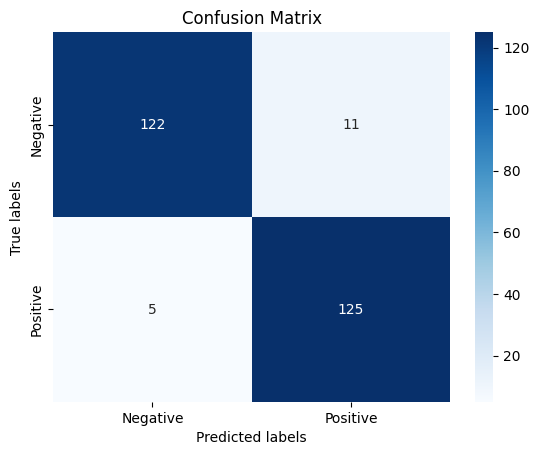

In [129]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Построение матрицы ошибок
cm = confusion_matrix(true_labels, preds)

# Визуализация матрицы ошибок
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.title('Confusion Matrix')
plt.show()